Todos:
* generate test data set
    - number of clusters
    - space between clusters (from this the max pivot deviation is calculated)
    - values per cluster (also random range possible, then the start and end e.g. 10-42 should be possible -make adapted function for this- )
* is the above okay since it is a unique distribution and cluster centers might vary... in the beginning yes, it is one of many tests and this one tests specifically how ant clust performs on many uniformly distributed clusters. 

Idea:
* make function that generates the set
* each cluster has a pivot element from which single data points deviate.
* the pivot is a unique cluster id (no need to label the clusters)
    
    
    

# imports

In [1]:
# make AntClus dir known
import sys

sys.path.append("../AntClust")

# generally used
import random as rng

import matplotlib.pyplot as plt
import numpy as np
from AntClust import AntClust
from distance_classes import similarity_1d
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from rules import labroche_rules

# data generation

In [2]:
def uniform_cluster_data_random(
    num_clusters,
    cluster_width,
    values_per_cluster_min=0,
    values_per_cluster_max=100,
    rng_seed=1,
):
    """
    Makes a series of numbers that can be clustered together.
    Each cluster is getting a pivot element, starting by one and counts to
    num_clusters. From this a random deviation is generated which will be
    the new data point. If the deviation is to larg there will be a string
    of numbers with no space in between and as such no clusters.
    cluster_width: how far can the data point be from its pivot,
    only values <0.25 makes sense.
    """
    # variables
    data = []
    labels = []

    rng.seed(rng_seed)
    rand_min = -cluster_width
    rand_max = cluster_width
    rand_range = rand_max - rand_min

    # make data for each cluster pivot
    for c_pivot in range(1, num_clusters + 1):
        c_data = []
        c_labels = []

        # how many values to generate?
        values_per_cluster = rng.randint(values_per_cluster_min, values_per_cluster_max)
        # generate data points
        for n in range(0, values_per_cluster):
            # calc pivot deviation and add it
            dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # check if exist and if create new
            while dp in c_data:
                dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # add it with the labe to the cluster data
            c_data.append(dp)
            c_labels.append(c_pivot - 1)

        # add the cluster data to overall data
        data = data + c_data
        labels = labels + c_labels

    return data, labels


def uniform_cluster_data(num_clusters, cluster_width, values_per_cluster, rng_seed=1):
    """
    Makes a series of numbers that can be clustered together.
    Each cluster is getting a pivot element, starting by one and counts to
    num_clusters. From this a random deviation is generated which will be
    the new data point. If the deviation is to larg there will be a string
    of numbers with no space in between and as such no clusters.
    cluster_width: how far can the data point be from its pivot,
    only values <0.25 makes sense.
    """
    # variables
    data = []
    labels = []

    rng.seed(rng_seed)
    rand_min = -cluster_width
    rand_max = cluster_width
    rand_range = rand_max - rand_min

    # make data for each cluster pivot
    for c_pivot in range(1, num_clusters + 1):
        c_data = []
        c_labels = []

        # generate data points
        for n in range(0, values_per_cluster):
            # calc pivot deviation and add it
            dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # check if exist and if create new
            while dp in c_data:
                dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # add it with the labe to the cluster data
            c_data.append(dp)
            c_labels.append(c_pivot - 1)

        # add the cluster data to overall data
        data = data + c_data
        labels = labels + c_labels

    return data, labels


def make_cluster_mask(clust_labels):
    """
    This function will make a cluster mask which will
    hold the start and end index from each cluster.
    """
    clust_mask = []
    # get current clust
    current_clust_label = clust_labels[0]
    current_clust_start = 0

    # loop through all clusts
    for i in range(len(clust_labels)):
        if clust_labels[i] != current_clust_label:
            clust_mask.append([current_clust_start, i - 1])
            current_clust_label = clust_labels[i]
            current_clust_start = i
    # append the final mask
    clust_mask.append([current_clust_start, i])

    return clust_mask


def error_cluster_mask(cluster_result, cluster_mask, print_error_per_cluster=False):
    """
    Will test the cluster error based on the cluster mask approach.
    For every cluster in the mask it is checked how many clusters where found
    in the respective area. It is determined based on the highest representation
    number how many how many missclassified data points exist.
    It is assumed that the cluster labels are ascendendly ordered and no number
    in that row is missing, e.g.:
    correct : [0,0,0,0,1,1,1,2,2,...]
    false   : [0,0,0,3,3,2,2,....]
    """
    # vars
    cluster_errors = []
    already_used_labels = []

    # find the most significant number inside the clust range
    for c_range in cluster_mask:
        label_dict = {}

        # count numbers inside the cluster range
        for i in range(c_range[0], c_range[1] + 1):
            if cluster_result[i] not in label_dict:
                label_dict[cluster_result[i]] = 1
            else:
                label_dict[cluster_result[i]] += 1
        # find most dominant one, going to assumt this is the cluster label.
        # If two labels are equally dominant use the first occured
        max_index = np.where(
            list(label_dict.values()) == np.max(list(label_dict.values()))
        )[0][0]
        max_key = list(label_dict.keys())[max_index]

        # save nums with key and occurence and clust range index
        # count highest
        # if used check the occurences
        # if occurence here more then reassign and remove from the old one
        #     and find a new one for the old one by counting and us one that es not already used
        #     If no is found assign no cluster label
        # else (occurence less) go through all others until found one that is not used
        #     if all are used assign no label
        # save the labels in a list where [clust_range, label]
        # then you can go throug that list and count the errors (full error if label -1)

        # count for errors
        # now check how many of the same label are inside the cluster which tells
        # the ones that are correctly clustered.
        num_correct = 0
        for i in range(c_range[0], c_range[1] + 1):
            if cluster_result[i] == max_key:
                num_correct += 1

        # calc and append error
        cluster_errors.append(1 - (num_correct / (c_range[1] - c_range[0] + 1)))

    # return overall error
    if print_error_per_cluster:
        print(cluster_errors)
    return sum(cluster_errors) / len(cluster_errors)


# TODO:
# - run with different seeds and take the mean error
def run_benchmark():
    # generate two for loops that generate the data and then run antclust
    # and save the error to a 2d list of lists

    return []

# test functions


In [3]:
from sklearn.metrics import adjusted_rand_score, rand_score


def run_cluster_test_static(
    clusters_min, clusters_max, values_min, values_max, cluster_width, seed=3
):
    # variables
    fitness_ari = []
    fitness_ri = []

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        print(f"testing values for {num_clusters} clusters")
        for values_per_cluster in range(values_min, values_max + 1):
            # ------------------
            # data
            # ------------------
            data, labels = uniform_cluster_data(
                num_clusters, cluster_width, values_per_cluster, seed
            )
            data = np.array(data)
            labels = np.array(labels)

            # ------------------
            # run clustering
            # ------------------
            # similarity function
            f_sim = [similarity_1d(data.min(), data.max())]

            # rules
            rules = labroche_rules()

            # AntClust
            ant_clust = AntClust(
                data, f_sim, rules, alpha_ant_meeting_iterations=150, print_status=False
            )

            # find clusters
            ant_clust.find_clusters()

            # get the clustering result
            clusters_found = ant_clust.get_clusters()

            # ------------------
            # calc error
            # ------------------
            # use ari as score
            ari = adjusted_rand_score(labels, clusters_found)
            c_fitness_ari.append(ari)

            # use ri as score
            ri = rand_score(labels, clusters_found)
            c_fitness_ri.append(ri)

        # append fitness for that cluster ammount
        fitness_ari.append(c_fitness_ari)
        fitness_ri.append(c_fitness_ri)

    # finally
    return fitness_ari, fitness_ri


def run_cluster_test_dynamic(
    clusters_min,
    clusters_max,
    values_per_cluster_min,
    values_per_cluster_max,
    cluster_width,
    tests_per_clusters,
    seed=3,
):
    """
    Will run n tests_per_clusters where each test contains w clusters with
    a random ammount of data points in each cluster.
    Returns [[e_1, e_2,...], [e_1,..]]
    where the index ranges from clusters_min until clusters_max and
    e_n is the error for the a specific run.
    """
    # variables
    fitness_ari = []
    fitness_ri = []
    # set random seed for reproducability
    rng.seed(seed)

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        print(f"testing values for {num_clusters} clusters")
        for _ in range(0, tests_per_clusters):
            # ------------------
            # data
            # ------------------
            data, labels = uniform_cluster_data_random(
                num_clusters,
                cluster_width,
                values_per_cluster_min,
                values_per_cluster_max,
                rng_seed=rng.randint(0, sys.maxsize)
            )
            data = np.array(data)
            labels = np.array(labels)

            # ------------------
            # run clustering
            # ------------------
            # similarity function
            f_sim = [similarity_1d(data.min(), data.max())]

            # rules
            rules = labroche_rules()

            # AntClust
            ant_clust = AntClust(
                data, f_sim, rules, alpha_ant_meeting_iterations=150, print_status=False
            )

            # find clusters
            ant_clust.find_clusters()

            # get the clustering result
            clusters_found = ant_clust.get_clusters()

            # ------------------
            # calc error
            # ------------------
            # use ari as score
            ari = adjusted_rand_score(labels, clusters_found)
            c_fitness_ari.append(ari)

            # use ri as score
            ri = rand_score(labels, clusters_found)
            c_fitness_ri.append(ri)

        # append fitness for that cluster ammount
        fitness_ari.append(c_fitness_ari)
        fitness_ri.append(c_fitness_ri)

    # finally
    return fitness_ari, fitness_ri

# plot functions

In [4]:
import matplotlib
def plot_3d(X, Y, Z):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.dpi = 142

    # Plot the surface.
    # surf = ax.plot_surface(X, Y, Z, cmap=cm.RdBu, linewidth=0, antialiased=True)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.PiYG, linewidth=0, antialiased=True)

    # Customize the z axis.
    ax.set_zlim(-0.0, 1.0)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter("{x:.02f}")

    # set axis labels
    plt.xlabel("clusters")
    plt.ylabel("datapoints")
    plt.xticks(X[0])

    # ax.text(5, 0, 1, "5", color='red')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

# static cluster performance

In [5]:
# ------------------
# test static
# ------------------
clusters_min = 2
clusters_max = 20
values_min = 4
values_max = 70
cluster_width = 0.1  # this defines how hard the clustering task is?
seed = 9

fitness_static_ari, fitness_static_ri = run_cluster_test_static(
    clusters_min, clusters_max, values_min, values_max, cluster_width, seed=seed
)

testing values for 2 clusters
testing values for 3 clusters
testing values for 4 clusters
testing values for 5 clusters
testing values for 6 clusters
testing values for 7 clusters
testing values for 8 clusters
testing values for 9 clusters
testing values for 10 clusters
testing values for 11 clusters
testing values for 12 clusters
testing values for 13 clusters
testing values for 14 clusters
testing values for 15 clusters
testing values for 16 clusters
testing values for 17 clusters
testing values for 18 clusters
testing values for 19 clusters
testing values for 20 clusters


# 3D plots

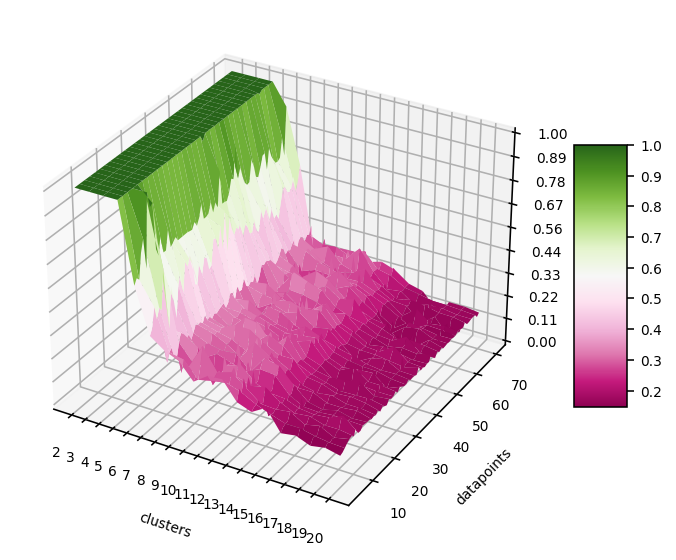

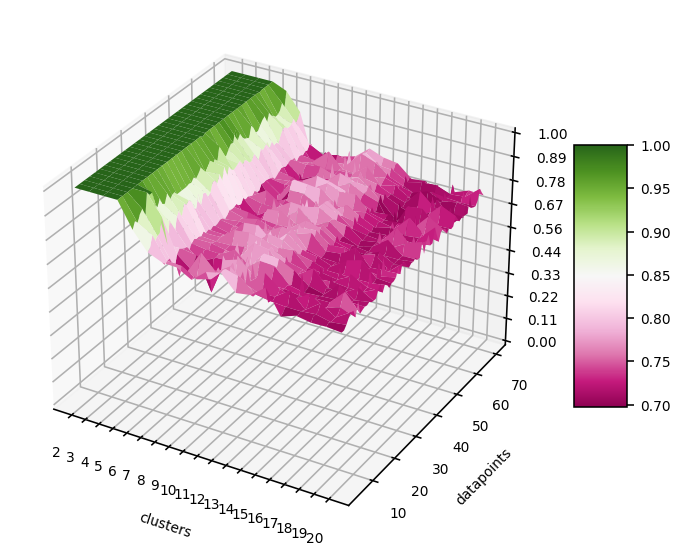

In [6]:
# axis
X = np.arange(clusters_min, clusters_max + 1, 1)
# X = X[::-1]
Y = np.arange(values_min, values_max + 1, 1)
# Y = Y[::-1]
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)

# Ari
Z = np.array(fitness_static_ari).transpose()
# Z = Z[::-1]
# print(Z)
# set font
plt.rcParams.update({'font.size': 7})
plot_3d(X, Y, Z)

# Ar
Z = np.array(fitness_static_ri).transpose()
plot_3d(X, Y, Z)

# 2D plot of specific data point

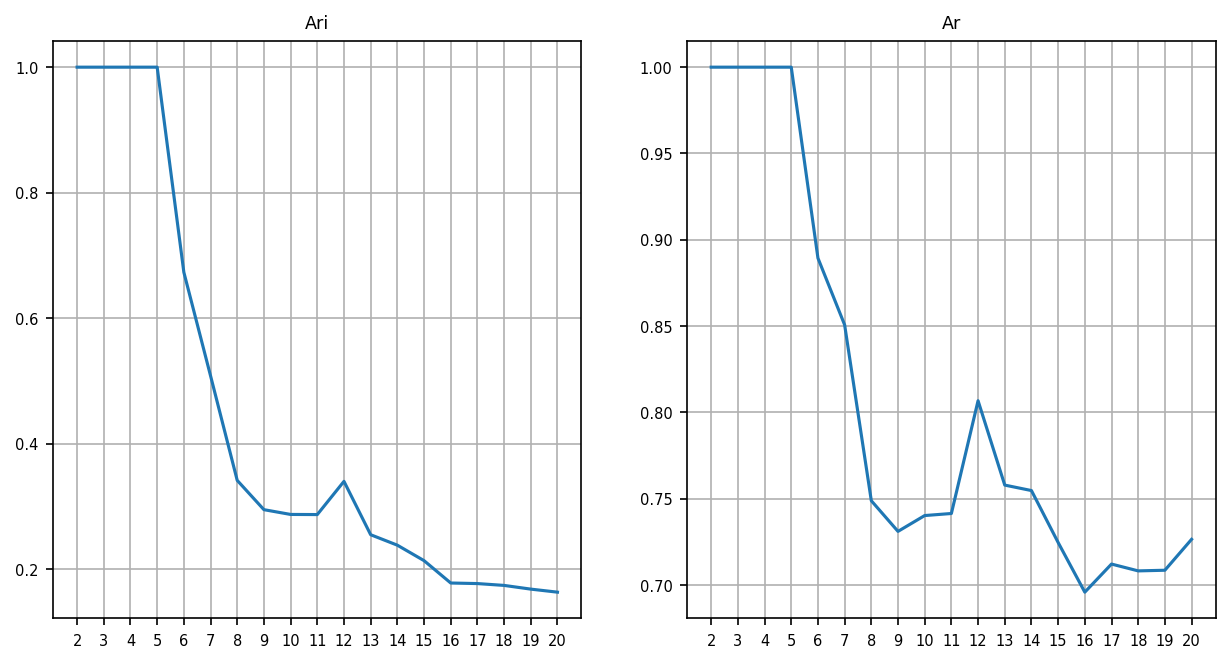

In [7]:
# ari
data_point = int(len(fitness_static_ari[0]) / 2)
test_data_fixed_points_ari = []
for i in range(0, (clusters_max - clusters_min) + 1):
    test_data_fixed_points_ari.append(fitness_static_ari[i][data_point])


data_point = int(len(fitness_static_ri[0]) / 2)
test_data_fixed_points_ar = []
for i in range(0, (clusters_max - clusters_min) + 1):
    test_data_fixed_points_ar.append(fitness_static_ri[i][data_point])

X = np.arange(clusters_min, clusters_max + 1, 1)


plt.figure(figsize=(10, 5), dpi=150)
plt.subplot(121)
plt.title("Ari")
plt.plot(X, test_data_fixed_points_ari)
plt.grid()
plt.xticks(X)

plt.subplot(122)
plt.title("Ar")
plt.plot(X, test_data_fixed_points_ar)
plt.grid()
plt.xticks(X)

plt.show()

# dynamic performance

In [8]:
# ------------------
# test dynamic
# ------------------
# test vars
cluster_width = 0.1  # this defines how hard the clustering task is?
clusters_min = 2
clusters_max = 20
values_per_cluster_min = 4
values_per_cluster_max = 70
tests_per_clusters = 30
seed = 7

# run test
fitness_dynamic_ari, fitness_dynamic_ri = run_cluster_test_dynamic(
    clusters_min,
    clusters_max,
    values_per_cluster_min,
    values_per_cluster_max,
    cluster_width,
    tests_per_clusters,
    seed,
)

# calc mean and std
mean_ari = []
min_ari = []
max_ari = []
mean_ar= []
min_ar = []
max_ar = []

for i_ari, i_ar in zip(fitness_dynamic_ari, fitness_dynamic_ri):
    # ari
    mean_ari.append(np.mean(i_ari))
    min_ari.append(np.min(i_ari))
    max_ari.append(np.max(i_ari))
    
    # ar
    mean_ar.append(np.mean(i_ar))
    min_ar.append(np.min(i_ar))
    max_ar.append(np.max(i_ar))
# as np
mean_ari = np.array(mean_ari)
min_ari = np.array(min_ari)
max_ari = np.array(max_ari)
mean_ar = np.array(mean_ar)
min_ar = np.array(min_ar)
max_ar = np.array(max_ar)

testing values for 2 clusters
testing values for 3 clusters
testing values for 4 clusters
testing values for 5 clusters
testing values for 6 clusters
testing values for 7 clusters
testing values for 8 clusters
testing values for 9 clusters
testing values for 10 clusters
testing values for 11 clusters
testing values for 12 clusters
testing values for 13 clusters
testing values for 14 clusters
testing values for 15 clusters
testing values for 16 clusters
testing values for 17 clusters
testing values for 18 clusters
testing values for 19 clusters
testing values for 20 clusters


# plot dynamic test performance

[]

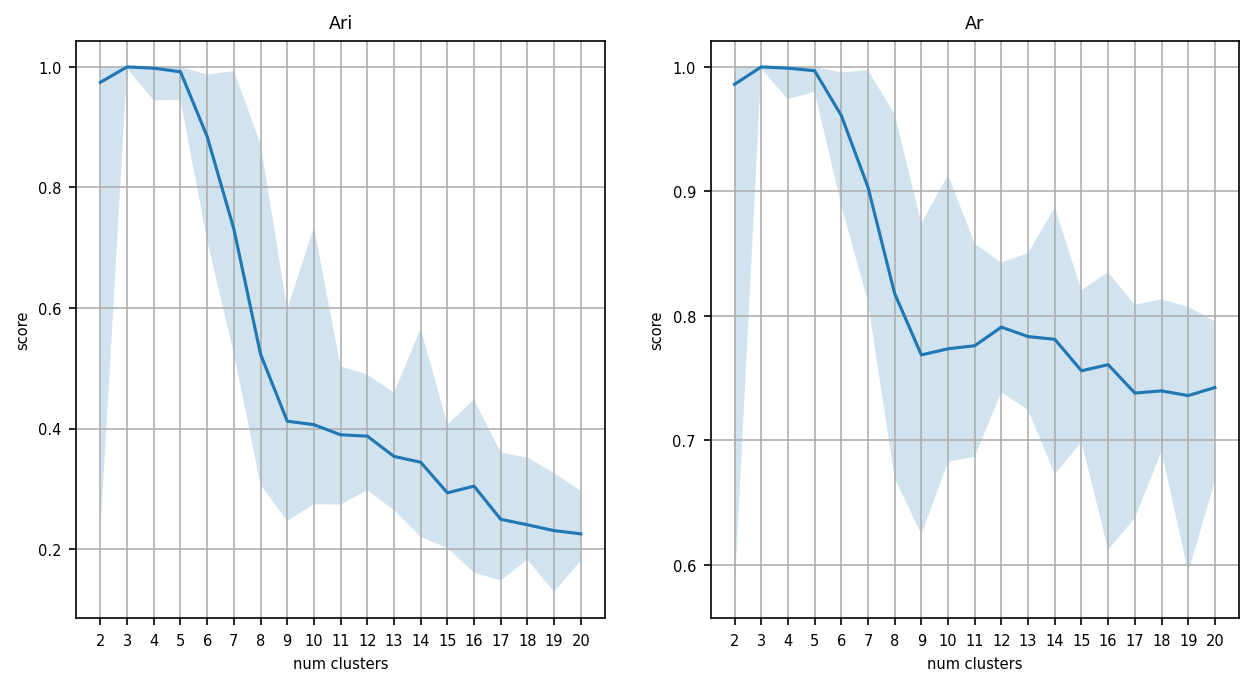

In [9]:
X = np.arange(clusters_min, clusters_max + 1, 1)


plt.figure(figsize=(10, 5), dpi=150)
plt.subplot(121)
plt.title("Ari")
plt.xlabel('num clusters')
plt.ylabel('score')
plt.plot(X, mean_ari)
plt.fill_between(X, min_ari, max_ari, alpha=0.2)
plt.grid()
plt.xticks(X)

plt.subplot(122)
plt.title("Ar")
plt.xlabel('num clusters')
plt.ylabel('score')
plt.plot(X, mean_ar)
plt.fill_between(X, min_ar, max_ar, alpha=0.2)
plt.grid()
plt.xticks(X)

plt.plot()

In [10]:
 mean_ari - std_ari

NameError: name 'std_ari' is not defined

In [ ]:
mean_ari

# playing

In [ ]:
# ------------------
# data
# ------------------
num_clusters = 5
cluster_width = 0.1  # this defines how hard the clustering task is?
values_per_cluster = 100
data, labels = uniform_cluster_data(
    num_clusters, cluster_width, values_per_cluster, rng_seed=3
)
data = np.array(data)
labels = np.array(labels)

cluster_mask = make_cluster_mask(labels)
error_cluster_mask(labels, cluster_mask)
cluster_mask

In [ ]:
# ------------------
# data
# ------------------
num_clusters = 30
cluster_width = 0.1  # this defines how hard the clustering task is?
values_per_cluster = 10
data, labels = uniform_cluster_data(
    num_clusters, cluster_width, values_per_cluster, rng_seed=3
)
data = np.array(data)
labels = np.array(labels)

# ------------------
# AntClust
# ------------------
# similarity function
f_sim = [similarity_1d(data.min(), data.max())]

# rules
rules = labroche_rules()

# AntClust
ant_clust = AntClust(data, f_sim, rules, alpha_ant_meeting_iterations=150)

# find clusters
ant_clust.find_clusters()

# get the clustering result
clusters_found = ant_clust.get_clusters()

# ------------------
# performance
# ------------------
# how many labels differ?
num_missclassified = len(np.where(clusters_found != labels)[0])
error = num_missclassified / len(data)
print(f"label error: {error}")

# error with cluster mask approach
cluster_mask = make_cluster_mask(labels)
error = error_cluster_mask(clusters_found, cluster_mask, print_error_per_cluster=True)
print(f"cluster mask error: {error}")

# labels found
print(f"clusters found ids \n")
clusters_found

In [ ]:
from sklearn.metrics import (
    adjusted_rand_score,
    davies_bouldin_score,
    mutual_info_score,
    rand_score,
    silhouette_score,
)

# RI = (number of agreeing pairs) / (number of pairs)
ris = rand_score(labels, clusters_found)
print(ris)

# ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
ari = adjusted_rand_score(labels, clusters_found)
print(ari)

#
# ss = silhouette_score(labels, clusters_found)

# print(ss)


#
# dbs = davies_bouldin_score(labels, clusters_found)
# print(dbs)


mis = mutual_info_score(labels, clusters_found)
print(mis)